In [26]:
import pandas as pd

X = pd.read_csv('x_v1.csv')
y = pd.read_csv('target_v1.csv')

In [27]:
rolls = [5, 15, 30, 60, 120]
columns_to_roll = ['ProcessingTime', 'config', 'is_dep_B', 'is_local', 'departure_equals_checkin']
rolled = [X]

for roll in rolls:
    rolled.append(X[columns_to_roll].rolling(roll).mean().rename(columns={c: c+f'_{roll}' for c in columns_to_roll}))
    rolled.append(y.rolling(roll).mean().rename(columns={'target': f'target_{roll}'}))
    
X = pd.concat(rolled, axis=1)
X /= X.max(axis=0)
    
X = X.iloc[max(rolls):]
y = y.iloc[max(rolls):]

In [28]:
import numpy as np

def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs(y_true-y_pred)/y_true)

def median_absolute_error(y_true, y_pred):
    return np.median(np.abs(y_true-y_pred))

def qloss(y_true, y_pred, q):
    return (np.sum(np.maximum(y_true - y_pred, 0) * q) / np.sum(y_true <= y_pred) + 
            np.sum(np.maximum(y_pred - y_true, 0) * (1-q)) / np.sum(y_true > y_pred))

In [32]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import joblib

tscv = TimeSeriesSplit(n_splits=5)
for train_idx, val_idx in tscv.split(X):
    train_X = X.iloc[train_idx].to_numpy()
    train_y = y.iloc[train_idx].to_numpy().ravel()
    
    val_X = X.iloc[val_idx].to_numpy()
    val_y = y.iloc[val_idx].to_numpy().ravel()
    
    estimator = LinearRegression()
    estimator.fit(train_X, train_y)
    
    joblib.dump(estimator, './models/all_comp_model.pkl')
    
    y_pred = estimator.predict(val_X)
    
    print(f'split: {round(len(train_idx)/len(X), 2)}/{round(len(val_idx)/len(X), 2)}, \
    MedAE: {round(median_absolute_error(val_y, y_pred), 6)}, \
    MedAPE: {round(median_absolute_percentage_error(val_y, y_pred), 6)}, \
    MAPE: {round(mean_absolute_percentage_error(val_y, y_pred), 6)}, \
    QLoss80: {round(qloss(val_y, y_pred, 0.8), 6)}, QLoss95: {round(qloss(val_y, y_pred, 0.95), 6)}')

split: 0.17/0.17,     MedAE: 2.520931,     MedAPE: 0.118999,     MAPE: 0.162198,     QLoss80: 2.993888, QLoss95: 2.965604
split: 0.33/0.17,     MedAE: 2.507048,     MedAPE: 0.120451,     MAPE: 0.166815,     QLoss80: 3.040597, QLoss95: 3.002513
split: 0.5/0.17,     MedAE: 2.506807,     MedAPE: 0.120046,     MAPE: 0.162549,     QLoss80: 2.983782, QLoss95: 2.955378
split: 0.67/0.17,     MedAE: 2.566452,     MedAPE: 0.116587,     MAPE: 0.157694,     QLoss80: 3.016375, QLoss95: 2.982502
split: 0.83/0.17,     MedAE: 2.536369,     MedAPE: 0.118138,     MAPE: 0.162163,     QLoss80: 2.975677, QLoss95: 2.936146


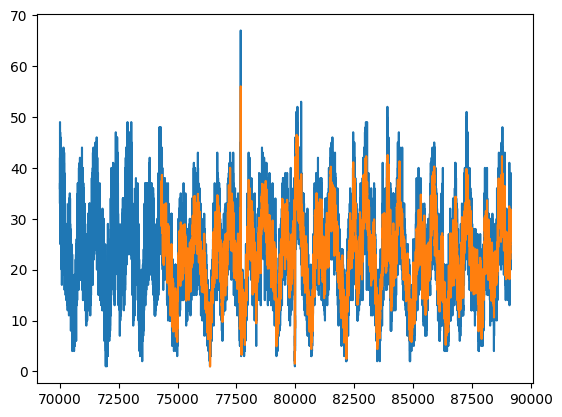

In [30]:
import matplotlib.pyplot as plt

plt.plot(np.arange(X.shape[0])[70000:], y[70000:])
plt.plot(val_idx, y_pred)

In [31]:
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import numpy as np

selector = RFECV(LinearRegression(), step=1, cv=tscv.split(X))
selector.fit(X.to_numpy(), y.to_numpy())

for c, r in zip(X.columns, selector.ranking_):
    if r > 1:
        print(c, r)

dep_day 15
dep_hour 3
0 12
2 9
5 6
6 11
7 17
8 10
is_dep_B_15 8
is_local_15 7
is_dep_B_30 4
ProcessingTime_60 16
config_60 2
is_dep_B_60 13
is_dep_B_120 5
departure_equals_checkin_120 14
